In [1]:
import numpy as np
import pandas as pd
import keras
from scipy import sparse
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline

Using TensorFlow backend.


In [2]:
business = pd.read_csv('/Users/11kolop/Applied Data Science/business.csv')
review_all = pd.read_csv('/Users/11kolop/Applied Data Science/review.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (57,59,60) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
a = business[business['categories'].str.contains('Restaurant') == True]
b = business[business['city']=='Las Vegas']
rev = review_all[review_all.business_id.isin(a['business_id']) == True]
rev1 = rev[rev.business_id.isin(b['business_id'])==True]
test = rev1.sample(frac=0.20,random_state=42)
train = rev1.drop(test.index)
train = train[['text', 'stars']]
train = pd.get_dummies(train, columns = ['stars'])
test = test[['text', 'stars']]
test = pd.get_dummies(test, columns = ['stars'])
test = test.dropna()
train_samp = train.sample(frac=.05,random_state=42)
test_samp = test.sample(frac=.05,random_state=42)

In [19]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training auc')
    plt.plot(x, val_acc, 'r', label='Validation auc')
    plt.title('Training and validation ACC')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


In [20]:
embed_size = 200 
max_features = 20000
maxlen = 200
embedding_file = '/Users/11kolop/Downloads/glove.twitter.27B/glove.twitter.27B.200d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embedding_file))
class_names = ['stars_1', 'stars_2', 'stars_3', 'stars_4', 'stars_5']
y = train_samp[class_names].values
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train['text'].values))
X_train = tokenizer.texts_to_sequences(train_samp['text'].values.astype(str))
X_test = tokenizer.texts_to_sequences(test_samp['text'].values.astype(str))
x_train = pad_sequences(X_train, maxlen = maxlen)
x_test = pad_sequences(X_test, maxlen = maxlen)
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
missed = []
for word, i in word_index.items():
    if i >= max_features: break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        missed.append(word)


In [21]:
from keras.models import load_model
inp = Input(shape = (maxlen,))
x = Embedding(max_features, embed_size, weights = [embedding_matrix], trainable = True)(inp)
x = SpatialDropout1D(0.5)(x)
x = Bidirectional(LSTM(40, return_sequences=True))(x)
x = Bidirectional(GRU(40, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(5, activation = 'sigmoid')(conc)
model = Model(inputs = inp, outputs = outp)
earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5)
checkpoint = ModelCheckpoint(monitor = 'val_loss', save_best_only = True, filepath = 'best_model_one.h5')
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
history = model.fit(x_train, y, batch_size = 512, epochs = 20, validation_split = .1,
          callbacks=[earlystop, checkpoint])
saved_model_one = load_model('best_model_one.h5')
y_test = saved_model_one.predict([x_test], batch_size=1024, verbose = 1)
scores = saved_model_one.evaluate(x_test, test_samp[class_names].values, verbose = 1, batch_size=1024)
print("ACC:", scores[1]) 
v = metrics.classification_report(np.argmax(test_samp[class_names].values, axis = 1),np.argmax(y_test, axis = 1))
print(v)


Train on 44740 samples, validate on 4972 samples
Epoch 1/20
44740/44740 [==============================] - 299s 7ms/step - loss: 0.4511 - acc: 0.8097 - val_loss: 0.3744 - val_acc: 0.8375
Epoch 2/20
44740/44740 [==============================] - 296s 7ms/step - loss: 0.3536 - acc: 0.8446 - val_loss: 0.3166 - val_acc: 0.8546
Epoch 3/20
44740/44740 [==============================] - 300s 7ms/step - loss: 0.3202 - acc: 0.8550 - val_loss: 0.2974 - val_acc: 0.8629
Epoch 4/20
44740/44740 [==============================] - 321s 7ms/step - loss: 0.3017 - acc: 0.8615 - val_loss: 0.2902 - val_acc: 0.8655
Epoch 5/20
44740/44740 [==============================] - 279s 6ms/step - loss: 0.2913 - acc: 0.8657 - val_loss: 0.2855 - val_acc: 0.8660
Epoch 6/20
44740/44740 [==============================] - 247s 6ms/step - loss: 0.2823 - acc: 0.8691 - val_loss: 0.2843 - val_acc: 0.8646
Epoch 7/20
44740/44740 [==============================] - 269s 6ms/step - loss: 0.2749 - acc: 0.8725 - val_loss: 0.2864 - v

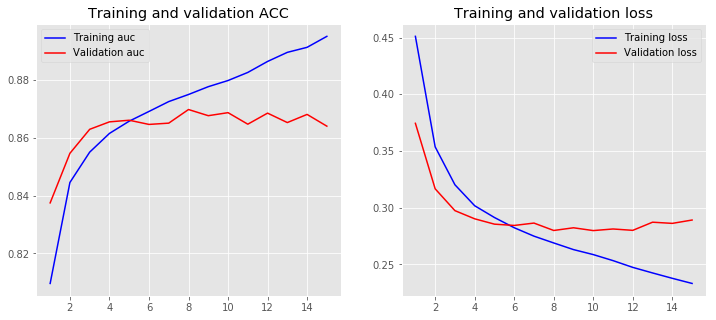

In [22]:
plot_history(history)

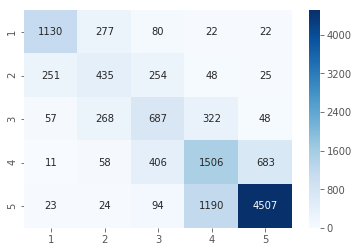

In [24]:
matrix = metrics.confusion_matrix(y_test.argmax(axis=1),test_samp[class_names].values.argmax(axis=1))
import seaborn as sns
labels = ['1', '2','3','4','5']
sns.heatmap(matrix,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2)

In [1]:
y_test

NameError: name 'y_test' is not defined